# Model Evaluation

In this notebook, we evaluate the performance of one or more binary classification models on a test dataset, with a special focus on confusion matrix analysis and threshold optimization for imbalanced data. We will calculate standard evaluation metrics and then improve the analysis by adjusting classification thresholds to reduce false positives while maintaining good recall. The key steps include:

* Baseline Evaluation (Threshold = 0.5): Compute the confusion matrix and metrics such as accuracy, precision, recall, F1-score, and ROC-AUC for each model using the default 0.5 threshold.

* Threshold Optimization: For each model, find the optimal probability threshold that maximizes the F1-score (balance of precision and recall). This helps address class imbalance by potentially improving recall or precision as needed.
Impact on False Positives: Visualize how changing the threshold affects the number of false positives and false negatives, using confusion matrices at different thresholds and plotting false positive rates (FPR) vs. threshold.

* ROC and Precision-Recall Curves: Plot the ROC curves and Precision-Recall curves for all models, including AUC annotations. These help compare models and identify which model better minimizes false positives (e.g. higher precision at a given recall).

* Final Evaluation: Recompute metrics and confusion matrices using the optimized thresholds for each model, and compare models to determine which one is preferable if reducing false alarms is a priority.

## Setup: Data and Model Preparation

We import all required packages: classifiers, metrics, plotting tools, and sparse matrix utilities.  
We also disable TPOT's use of Dask and suppress warnings for a cleaner output.

In [1]:
!pip install nltk


DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/multiprocess-0.70.17-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/TPOT-1.0.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/dill-0.3.9-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.12/site-packages/sklearn_genetic-0.6.0-py3.12.egg is deprecated. pip 24.3 will e

In [3]:
# Disable Dask usage in TPOT (Keep this if you still need it elsewhere)
import os
os.environ["TPOT_USE_DASK"] = "False"

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn and XGBoost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report,
    precision_recall_curve
)
from scipy.sparse import hstack, csr_matrix 

import warnings
warnings.filterwarnings('ignore')


try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False
    print("XGBoost not installed.")


# Resampling libraries
from imblearn.under_sampling import RandomUnderSampler

from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import StandardScaler


# Word2Vec imports
import nltk
nltk.download('punkt_tab')

try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')
import re
from nltk.corpus import stopwords

try:
    from gensim.models import Word2Vec
    gensim_available = True
except ImportError:
    gensim_available = False
    print("Gensim not installed. Please run: !pip install gensim==4.3.2")

print("All necessary libraries imported.")


print("Downloading NLTK data...")
nltk.download('punkt')
nltk.download('stopwords')
print("NLTK data download complete.")

seed = 42

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/rsalvatori/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


All necessary libraries imported.
NLTK data download complete.


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rsalvatori/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rsalvatori/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load and prepare Data

We load the preprocessed CSV dataset, separate text and numeric features, apply TF-IDF vectorization, and combine the features into a sparse matrix `X_all`.  
The target `y` is the binary label. We print the label distribution to understand class imbalance.

In [5]:
# Load data
url = "formated/train_exportado.csv"
df = pd.read_csv(url)

print("Datos cargados correctamente\n")

selected_features = [

    'statement-raw',
    'feelings',
    'subject-ciencia_y_tecnologia', 'subject-economia_y_finanzas',
    'subject-educacion', 'subject-medio_ambiente_y_energia', 'subject-otros',
    'subject-politica_y_gobierno', 'subject-relaciones_internacionales',
    'subject-salud_y_bienestar', 'subject-seguridad_y_justicia',
    'subject-sociedad_y_cultura', 'subject-trabajo_y_empleo',
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod'
]



numeric_vars = [
    'speaker_grouped_cod', 'speaker_job_grouped_cod',
    'state_info_grouped_cod', 'party_group_cod',
]


X = df[selected_features].copy() 
y = df['label']

# --- Word2Vec Implementation (Replacing TF-IDF and SVD) ---

if not gensim_available:
    print("Gensim not available, skipping Word2Vec.")
else:
    stop_words = set(stopwords.words('english'))

    def preprocess_text(text):
        """Helper function to preprocess text for Word2Vec."""
        text = str(text) # Ensure text is string
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) 
        words = nltk.word_tokenize(text) # Tokenize
        words = [word for word in words if word not in stop_words] # Remove stopwords
        return words

    # Apply preprocessing to the 'statement-raw' column
    processed_text = X['statement-raw'].apply(preprocess_text).tolist()

    # Train Word2Vec model
    # Adjust vector_size, window, min_count, and epochs as needed
    word2vec_model = Word2Vec(sentences=processed_text, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

    def document_vector(doc, model):
        """Helper function to create a document vector by averaging word vectors."""
        # Remove words not in the vocabulary
        doc = [word for word in doc if word in model.wv.index_to_key]
        if not doc:
            return np.zeros(model.vector_size) # Return zero vector if document is empty after filtering
        return np.mean(model.wv[doc], axis=0)

    # Create document vectors for 'statement-raw'
    X_word2vec = np.array([document_vector(doc, word2vec_model) for doc in processed_text])

    # Select other features (excluding the original text column)
    other_features = [col for col in selected_features if col != 'statement-raw']
    X_other = X[other_features].values

    # Combine Word2Vec vectors with other features
    # Since Word2Vec produces dense vectors, we can combine them directly
    X_combined = np.hstack((X_word2vec, X_other))

    print(f"Shape after combining features: {X_combined.shape}")


Datos cargados correctamente

Shape after combining features: (8950, 116)


## Define models

We define a dictionary of models to evaluate. For those that support it, we set `class_weight='balanced'` to help mitigate class imbalance.  
This includes linear models, tree-based models, neural nets, and SVMs with different kernels.

In [9]:
# Define models

models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42), # Ensure this is here
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'MLP': MLPClassifier(max_iter=1000, random_state=42),
    'Linear SVC': LinearSVC(max_iter=10000, random_state=42, class_weight='balanced'),
    'SVC_linear': SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced'),
    'SVC_rbf': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
    'SVC_poly': SVC(kernel='poly', probability=True, random_state=42, class_weight='balanced'),
    'SVC_sigmoid': SVC(kernel='sigmoid', probability=True, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'GaussianNB': GaussianNB()
}

if xgb_available:
    models['XGBoost'] = XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, scale_pos_weight=1)
else:
    print("XGBoost model not added (library not available).")


## Train-Test Split

We use an 80/20 stratified split to ensure the label distribution remains consistent between train and test sets.

In [11]:
# Apply Scaling to the numeric features within X_combined
# Identify the indices of the original numeric columns within X_combined
if gensim_available: # Only proceed if Word2Vec was successfully created
    word2vec_vector_size = word2vec_model.vector_size # Get actual vector size
    original_other_features = [col for col in selected_features if col != 'statement-raw']

    # Find the indices of the numeric_vars within original_other_features
    numeric_indices_in_other = [original_other_features.index(var) for var in numeric_vars if var in original_other_features]

    # The actual indices in X_combined will be offset by the word2vec_vector_size
    # We also need to account for the order of columns after hstack.

    feature_names_in_combined = [f'word2vec_{i}' for i in range(word2vec_vector_size)] + original_other_features
    feature_to_index = {name: i for i, name in enumerate(feature_names_in_combined)}

    # Get the indices of the numeric variables in X_combined
    numeric_indices_in_combined = [feature_to_index[var] for var in numeric_vars if var in feature_to_index]

    # Apply StandardScaler to the numeric columns
    scaler = StandardScaler()

    # Create a copy to avoid modifying X_combined directly
    X_scaled_array = X_combined.copy()

    # Scale the numeric columns in the copy
    if numeric_indices_in_combined: # Check if there are any numeric columns to scale
      X_scaled_array[:, numeric_indices_in_combined] = scaler.fit_transform(X_combined[:, numeric_indices_in_combined])

    X_scaled = X_scaled_array

    print(f"Shape after scaling: {X_scaled.shape}")

    # Apply Undersampling
    under = RandomUnderSampler(sampling_strategy=0.65, random_state=seed)
    X_undersampled, y_undersampled = under.fit_resample(X_scaled, y)

    counts = pd.Series(y_undersampled).value_counts()

    percentages = (counts / len(y_undersampled)) * 100

    print("Label distribution after Undersampling:")
    print(percentages)

    # Apply Oversampling (SMOTE)
    over = SMOTE(sampling_strategy=0.8, random_state=seed)
    X_resampled, y_resampled = over.fit_resample(X_undersampled, y_undersampled)

    counts = pd.Series(y_resampled).value_counts()

    percentages = (counts / len(y_resampled)) * 100

    print("\nLabel distribution after Oversampling (SMOTE):")
    print(percentages)

else:
    print("Skipping scaling and resampling as Word2Vec was not created.")

Shape after scaling: (8950, 116)
Label distribution after Undersampling:
label
1    60.601898
0    39.398102
Name: count, dtype: float64

Label distribution after Oversampling (SMOTE):
label
1    55.5581
0    44.4419
Name: count, dtype: float64


In [13]:
# Split dataset using resampled data
if 'X_resampled' in locals() and 'y_resampled' in locals():
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
    )
    print("Train-test split performed on resampled data.")
else:
     print("Resampled data not available. Train-test split skipped.")

Train-test split performed on resampled data.


## Evaluation with Threshold Tuning

For each model, we:
- Fit the model and get prediction probabilities or decision scores
- Sweep over thresholds from 0.1 to 0.9 to find the one maximizing F1
- Apply this threshold for predictions and plot the confusion matrix
- Print and store accuracy, precision, recall, F1, and ROC-AUC

This improves performance by reducing false positives or balancing metrics better than the default 0.5.

Evaluating: Random Forest


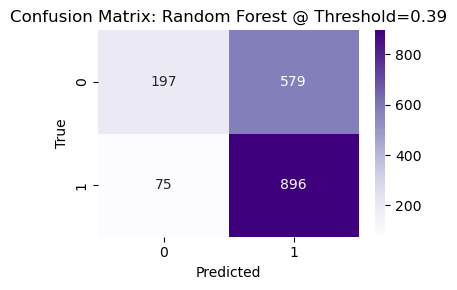

Accuracy: 0.626, Precision: 0.607, Recall: 0.923, F1: 0.733, ROC-AUC: 0.693
Optimal threshold for F1: 0.39
Evaluating: Gradient Boosting


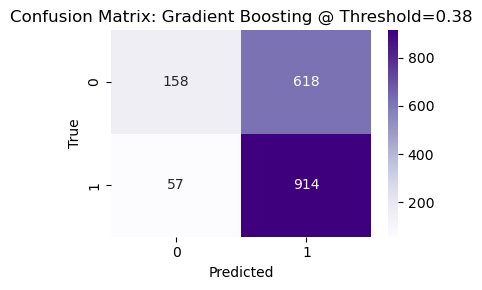

Accuracy: 0.614, Precision: 0.597, Recall: 0.941, F1: 0.730, ROC-AUC: 0.695
Optimal threshold for F1: 0.38
Evaluating: Decision Tree


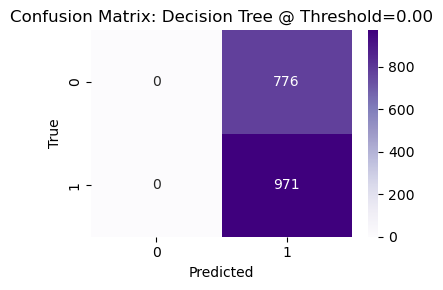

Accuracy: 0.556, Precision: 0.556, Recall: 1.000, F1: 0.714, ROC-AUC: 0.548
Optimal threshold for F1: 0.00
Evaluating: KNN


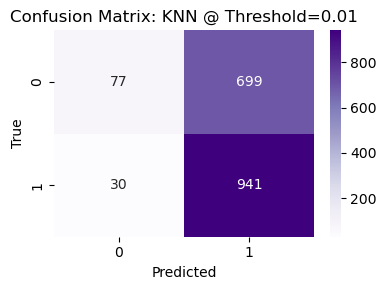

Accuracy: 0.583, Precision: 0.574, Recall: 0.969, F1: 0.721, ROC-AUC: 0.651
Optimal threshold for F1: 0.01
Evaluating: MLP


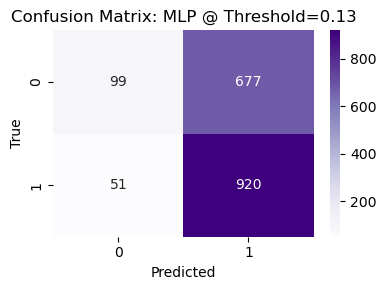

Accuracy: 0.583, Precision: 0.576, Recall: 0.947, F1: 0.717, ROC-AUC: 0.652
Optimal threshold for F1: 0.13
Evaluating: Linear SVC
Error evaluating Linear SVC: 'LinearSVC' object has no attribute 'predict_proba'
Evaluating: SVC_linear


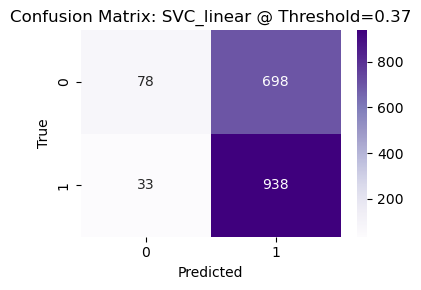

Accuracy: 0.582, Precision: 0.573, Recall: 0.966, F1: 0.720, ROC-AUC: 0.654
Optimal threshold for F1: 0.37
Evaluating: SVC_rbf


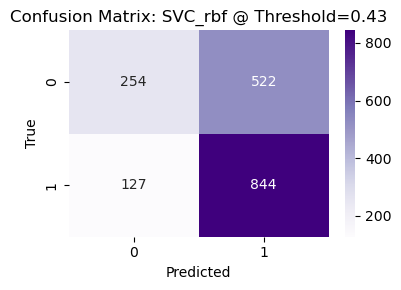

Accuracy: 0.629, Precision: 0.618, Recall: 0.869, F1: 0.722, ROC-AUC: 0.668
Optimal threshold for F1: 0.43
Evaluating: SVC_poly


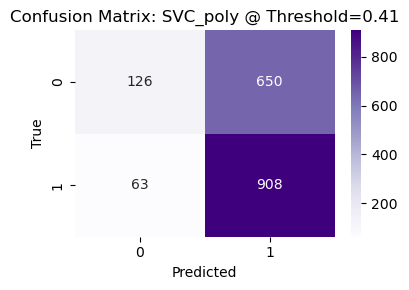

Accuracy: 0.592, Precision: 0.583, Recall: 0.935, F1: 0.718, ROC-AUC: 0.660
Optimal threshold for F1: 0.41
Evaluating: SVC_sigmoid


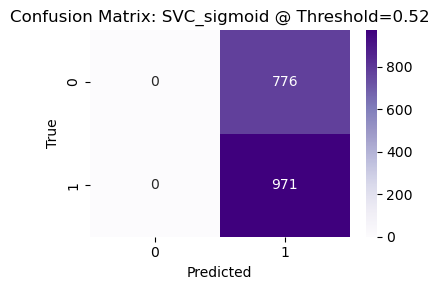

Accuracy: 0.556, Precision: 0.556, Recall: 1.000, F1: 0.714, ROC-AUC: 0.420
Optimal threshold for F1: 0.52
Evaluating: Logistic Regression


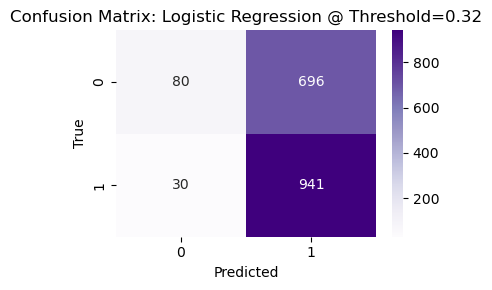

Accuracy: 0.584, Precision: 0.575, Recall: 0.969, F1: 0.722, ROC-AUC: 0.655
Optimal threshold for F1: 0.32
Evaluating: GaussianNB


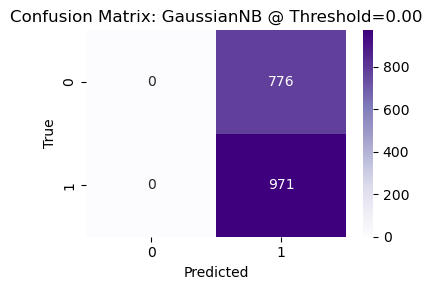

Accuracy: 0.556, Precision: 0.556, Recall: 1.000, F1: 0.714, ROC-AUC: 0.597
Optimal threshold for F1: 0.00
Evaluating: XGBoost


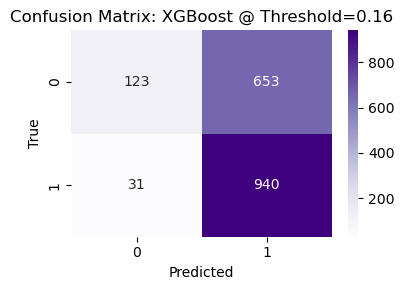

Accuracy: 0.608, Precision: 0.590, Recall: 0.968, F1: 0.733, ROC-AUC: 0.679
Optimal threshold for F1: 0.16


In [15]:
# Results and ROC curves storage
results = {}
roc_curves = {}
optimal_thresholds = {}

if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals() and 'y_test' in locals():
    for name, model in models.items():
        print(f"Evaluating: {name}")
        try:
            # Fit the model
            if name == 'GaussianNB':
                model.fit(X_train.toarray() if hasattr(X_train, 'toarray') else X_train,
                          y_train)
                y_score = model.predict_proba(X_test.toarray() if hasattr(X_test, 'toarray') else X_test)[:, 1]
            # LinearSVC and SVC with decision_function 
            elif name in ['LinearSVC'] and not hasattr(model, "predict_proba"):
                 model.fit(X_train, y_train)
                 # decision_function might return different scales, consider standardizing if needed
                 y_score = model.decision_function(X_test)
                 print(f"Warning: Using decision_function for {name}. ROC-AUC interpretation might differ.")
            else:
                # Assume other models have predict_proba or are handled by the general case
                model.fit(X_train, y_train)
                y_score = model.predict_proba(X_test)[:, 1]


            # Threshold sweep to maximize F1
            # Check if y_score has valid predictions (not all NaNs or infinities)
            if np.isnan(y_score).all() or np.isinf(y_score).all():
                 print(f"Skipping threshold tuning for {name} due to invalid y_score.")
                 # You might want to set default metrics or skip this model entirely
                 continue

            thresholds = np.linspace(y_score.min(), y_score.max(), 81)
            thresholds = np.sort(np.unique(thresholds))


            f1s = []
            # Handle potential errors in f1_score for edge cases
            for t in thresholds:
                try:
                    f1 = f1_score(y_test, (y_score >= t).astype(int))
                    f1s.append(f1)
                except Exception as f1_e:
                    print(f"Error calculating f1 for threshold {t:.2f} in {name}: {f1_e}")
                    f1s.append(-1) # Append a value that won't be selected as best


            if not f1s or max(f1s) == -1:
                 print(f"Could not find a valid threshold for {name}. Skipping.")
                 continue

            best_idx = np.argmax(f1s)
            best_threshold = thresholds[best_idx]
            optimal_thresholds[name] = best_threshold
            y_pred = (y_score >= best_threshold).astype(int)

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
            plt.title(f'Confusion Matrix: {name} @ Threshold={best_threshold:.2f}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.tight_layout()
            plt.show()

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            roc_auc = roc_auc_score(y_test, y_score) # ROC-AUC uses the raw scores

            results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': roc_auc}

            print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")
            print(f"Optimal threshold for F1: {best_threshold:.2f}")

            # Store ROC curve
            if not np.isnan(y_score).all() and not np.isinf(y_score).all():
                 fpr, tpr, _ = roc_curve(y_test, y_score)
                 roc_curves[name] = (fpr, tpr, roc_auc)
            else:
                 print(f"Skipping ROC curve for {name} due to invalid y_score.")

        except Exception as e:
            print(f"Error evaluating {name}: {e}")
else:
    print("Skipping model evaluation as train-test split was not performed.")

## Metric Comparison Plot

This horizontal bar chart compares each model across five key metrics:  
Accuracy, Precision, Recall, F1-score, and ROC-AUC, all computed using **optimal thresholds** per model.

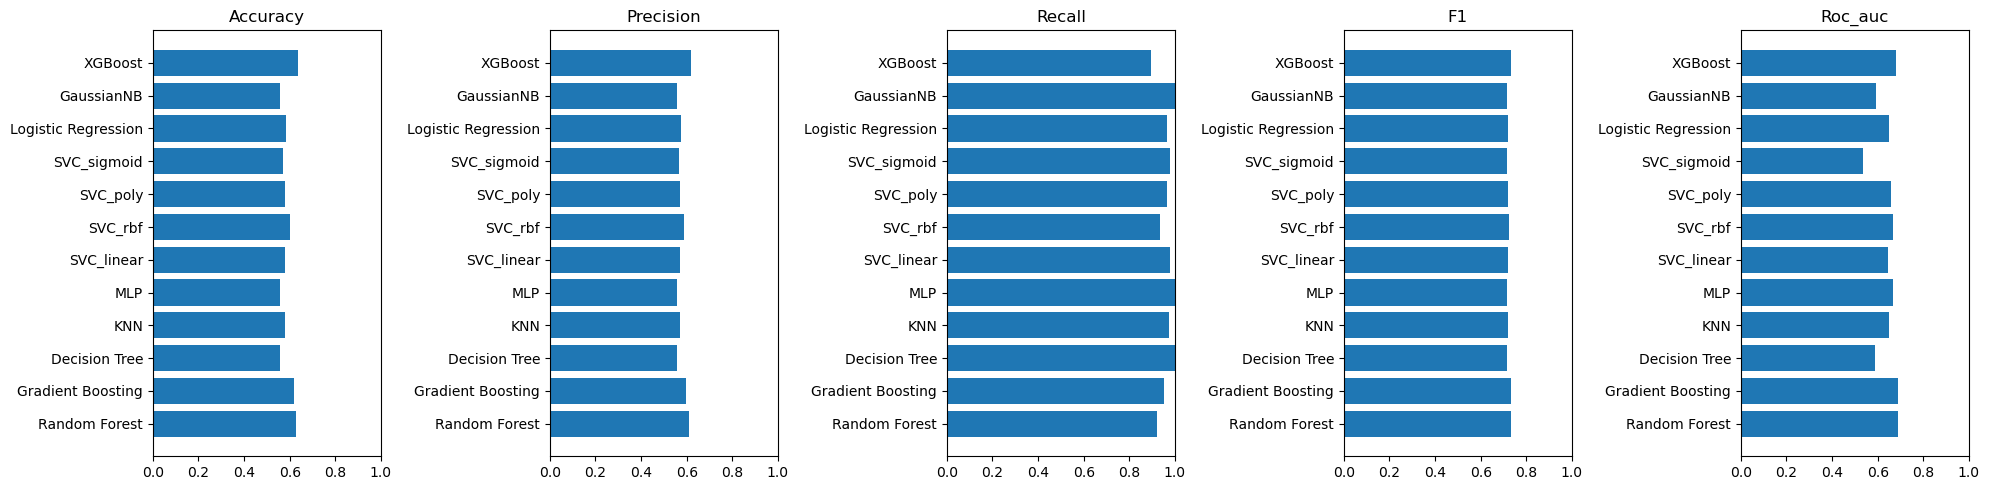

In [51]:
# Compare performance across models
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
fig, axs = plt.subplots(1, len(metrics), figsize=(20, 5))

for i, metric in enumerate(metrics):
    names = list(results.keys())
    values = [results[m][metric] for m in names]
    axs[i].barh(names, values)
    axs[i].set_title(metric.capitalize())
    axs[i].set_xlim(0, 1)

plt.tight_layout()
plt.show()

## ROC Curves Plot

This chart shows how well each model separates the classes.  
Better models have curves closer to the top-left, with higher **AUC** scores indicating stronger separation between positive and negative classes.

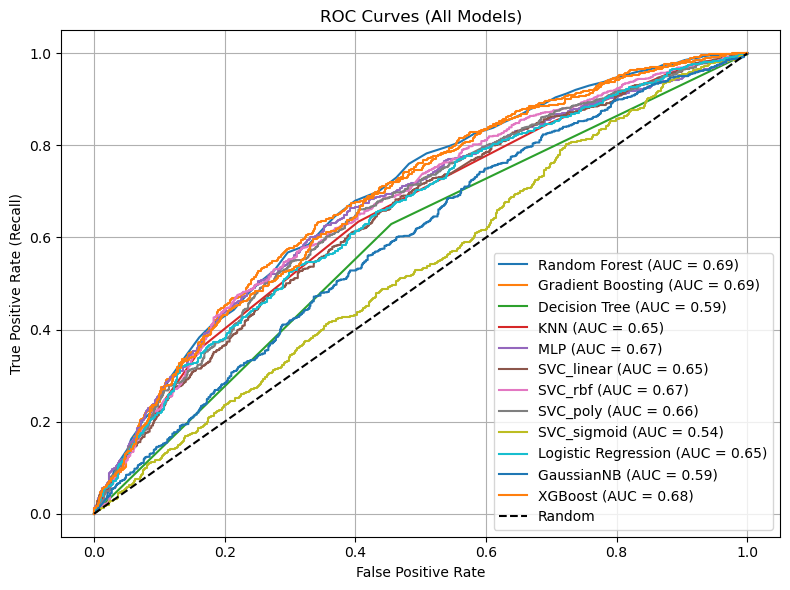

In [54]:
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves (All Models)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary Table

This table shows final performance for all models **at their best thresholds**, sorted by F1-score.  
You can now choose the model that best fits your use case:  
- If minimizing false positives: look for highest **precision**
- If catching more positives: look for highest **recall**
- For balance: highest **F1**

In [57]:
summary_df = pd.DataFrame(results).T.round(3)
summary_df['Best Threshold'] = summary_df.index.map(optimal_thresholds)
summary_df = summary_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'Best Threshold']]
summary_df.sort_values('f1', ascending=False)

,accuracy,precision,recall,f1,roc_auc,Best Threshold
Random Forest,0.629,0.610,0.921,0.734,0.688,4.000000e-01
Gradient Boosting,0.617,0.598,0.952,0.734,0.688,3.920043e-01
XGBoost,0.634,0.618,0.896,0.731,0.680,2.872789e-01
SVC_rbf,0.603,0.590,0.933,0.723,0.668,3.892868e-01
KNN,0.581,0.572,0.975,0.721,0.651,1.250000e-02
SVC_linear,0.580,0.572,0.977,0.721,0.646,3.677890e-01
Logistic Regression,0.584,0.575,0.967,0.721,0.649,3.191803e-01
SVC_poly,0.579,0.572,0.966,0.718,0.659,3.729399e-01
SVC_sigmoid,0.570,0.565,0.977,0.716,0.536,5.441081e-01
Decision Tree,0.556,0.556,1.000,0.714,0.587,0.000000e+00
